# Notebook d'exploration du graphe OSMnx

Dans ce notebook, je vais explorer la structure interne d'un graphe routier téléchargé avec OSMnx. Je vais examiner les nœuds, les arêtes et leurs attributs, et convertir le graphe en GeoDataFrames pour une analyse spatiale.

In [ ]:
%reset -f

Autosaving every 120 seconds


## Importation des bibliothèques nécessaires et chargement du graphe

In [59]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

## Zone de téléchargement des données

Le territoire d'étude est délimité par un polygone stocké dans un fichier GeoPackage.
Il s'agit d'un bounding box (cadre rectangulaire) autour de la ville de Marseille.

In [60]:
# Fonction pour charger un polygone de délimitation (zone d'étude) à partir d'un fichier GeoPackage
def load_bbox_polygon(gpkg_path, layer=None, geometry_index=0):
    """
    Load a bounding polygon from a GeoPackage (.gpkg) file.
    Reprojects it to WGS84 (EPSG:4326) if needed.

    Parameters
    ----------
    gpkg_path : str
        Path to the GeoPackage file.
    layer : str, optional
        Layer name (defaults to the first layer if not specified).
    geometry_index : int, optional
        Index of the geometry to extract (default is 0).

    Returns
    -------
    polygon : shapely.geometry.Polygon
    """

    # Load the GeoPackage layer
    gdf = gpd.read_file(gpkg_path, layer=layer)

    # Validate CRS and reproject to WGS84
    if gdf.crs is None:
        raise ValueError("The GeoPackage file has no defined CRS.")
    if gdf.crs.to_string().upper() != "EPSG:4326":
        gdf = gdf.to_crs("EPSG:4326")

    # Extract the polygon (default: first geometry)
    polygon = gdf.geometry.iloc[geometry_index]

    return polygon

In [61]:
# Charger le polygone de délimitation
polygon = load_bbox_polygon("../../Proximity/data/raw/personal/CadreMarseille.gpkg")

## Téléchargement du graphe routier avec OSMnx

Je fais appel à la fonction `graph_from_polygon` d'OSMnx pour télécharger le graphe routier dans la zone délimitée par le polygone.
Cette fonction télécharge les données depuis OpenStreetMap et construit un graphe dirigé où les nœuds représentent les intersections et les arêtes représentent les segments de route.

In [62]:
# Custom walk roads
custom_filter = (
    '["highway"~"primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|'
    'unclassified|residential|road|living_street|service|track|path|steps|pedestrian|'
    'footway|pier"]'
    '["highway"!~"platform"]'
    '["area"!~"yes"]["foot"!~"no"]'
)

In [63]:
G = ox.graph_from_polygon(polygon, custom_filter=custom_filter, simplify=True, retain_all=False)

In [64]:
# Type du graphe
print(type(G))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


Le graphe OSMnx est un MultiDiGraph de NetworkX, c’est-à-dire :

  * Multi : plusieurs arêtes possibles entre deux mêmes nœuds (routes parallèles, ponts, tunnels, sens uniques, etc.)

  * DiGraph : orienté (chaque arête a un sens, utile pour les voies à sens unique)

## Exploration de la structure du graphe

Ici je vais examiner les nœuds, les arêtes et leurs attributs pour comprendre la structure du graphe.

In [65]:
# Voir le nombre de nœuds et d'arêtes
print(G)

MultiDiGraph with 131477 nodes and 314833 edges


In [66]:
# Infos sur le graphe
G.graph

{'created_date': '2025-10-16 14:13:37',
 'created_with': 'OSMnx 1.7.1',
 'crs': 'epsg:4326',
 'simplified': True}

In [67]:
# Quelques edges 
list(G.edges(data=True))[:5]

[(12116512,
  1062102835,
  {'osmid': 1185889490,
   'ref': 'D 2',
   'name': 'Route de Saint-Pons',
   'highway': 'secondary',
   'oneway': False,
   'reversed': True,
   'length': np.float64(19.065)}),
 (12116512,
  12116520,
  {'osmid': 2682531,
   'highway': 'service',
   'oneway': False,
   'reversed': False,
   'length': np.float64(289.17900000000003),
   'geometry': <LINESTRING (5.636 43.295, 5.636 43.295, 5.636 43.296, 5.636 43.296, 5.635 4...>}),
 (12116512,
  12116535,
  {'osmid': 1185889490,
   'ref': 'D 2',
   'name': 'Route de Saint-Pons',
   'highway': 'secondary',
   'oneway': False,
   'reversed': False,
   'length': np.float64(77.251),
   'geometry': <LINESTRING (5.636 43.295, 5.636 43.295, 5.636 43.294)>}),
 (12116520,
  1846672547,
  {'osmid': 3626015,
   'ref': 'D 2',
   'name': 'Route de Saint-Pons',
   'highway': 'secondary',
   'oneway': False,
   'reversed': True,
   'length': np.float64(7.443)}),
 (12116520,
  12116512,
  {'osmid': 2682531,
   'highway': 'servi

In [68]:
# Quelques nœuds
list(G.nodes(data=True))[:5]

[(12116512, {'y': 43.2948921, 'x': 5.6357888, 'street_count': 3}),
 (12116520, {'y': 43.2962654, 'x': 5.6347066, 'street_count': 3}),
 (12116524, {'y': 43.2963012, 'x': 5.6338106, 'street_count': 3}),
 (12116526, {'y': 43.2964148, 'x': 5.6332916, 'street_count': 3}),
 (12116535, {'y': 43.2943835, 'x': 5.6364378, 'street_count': 3})]

In [69]:
# # Structure interne des données du graphe
# G._adj

In [70]:
# Premier élement du dcitionaire des nœuds
next(iter(G._adj.items()))

(12116512,
 {1062102835: {0: {'osmid': 1185889490,
    'ref': 'D 2',
    'name': 'Route de Saint-Pons',
    'highway': 'secondary',
    'oneway': False,
    'reversed': True,
    'length': np.float64(19.065)}},
  12116520: {0: {'osmid': 2682531,
    'highway': 'service',
    'oneway': False,
    'reversed': False,
    'length': np.float64(289.17900000000003),
    'geometry': <LINESTRING (5.636 43.295, 5.636 43.295, 5.636 43.296, 5.636 43.296, 5.635 4...>}},
  12116535: {0: {'osmid': 1185889490,
    'ref': 'D 2',
    'name': 'Route de Saint-Pons',
    'highway': 'secondary',
    'oneway': False,
    'reversed': False,
    'length': np.float64(77.251),
    'geometry': <LINESTRING (5.636 43.295, 5.636 43.295, 5.636 43.294)>}}})

In [71]:
# Liste des champs diponibles pour un nœud
next(iter(G.nodes(data=True)))[1].keys()

dict_keys(['y', 'x', 'street_count'])

In [72]:
# liste des attributs d'une arête
next(iter(G.edges(data=True)))[2].keys()

dict_keys(['osmid', 'ref', 'name', 'highway', 'oneway', 'reversed', 'length'])

In [73]:
# Les indices des arêtes
import pandas as pd
edges_index = pd.MultiIndex.from_tuples(G.edges(keys=True), names=["u", "v", "key"])
edges_index.to_frame(index=False).head()

,u,v,key
0,12116512,1062102835,0
1,12116512,12116520,0
2,12116512,12116535,0
3,12116520,1846672547,0
4,12116520,12116512,0


## Extraction des GeoDataFrames des nœuds et des arêtes

Maintenant que j'ai compris la structure du graphe, je vais extraire les GeoDataFrames des nœuds et des arêtes.
Pour se faire j'utilise les fonctions `graph_to_gdfs` d'OSMnx.

Voici ce que fais la fonction `graph_to_gdfs` :

```python
def graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True):
    """
    Convert a MultiDiGraph to node and/or edge GeoDataFrames.

    This function is the inverse of `graph_from_gdfs`.

    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    nodes : bool
        if True, convert graph nodes to a GeoDataFrame and return it
    edges : bool
        if True, convert graph edges to a GeoDataFrame and return it
    node_geometry : bool
        if True, create a geometry column from node x and y attributes
    fill_edge_geometry : bool
        if True, fill in missing edge geometry fields using nodes u and v

    Returns
    -------
    geopandas.GeoDataFrame or tuple
        gdf_nodes or gdf_edges or tuple of (gdf_nodes, gdf_edges). gdf_nodes
        is indexed by osmid and gdf_edges is multi-indexed by u, v, key
        following normal MultiDiGraph structure.
    """
```

In [74]:
# Convertir le graphe en GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

In [75]:
# Afficher les premières lignes 
nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
12116512,43.294892,5.635789,3,NaN,NaN,POINT (5.63579 43.29489)
12116520,43.296265,5.634707,3,NaN,NaN,POINT (5.63471 43.29627)
12116524,43.296301,5.633811,3,NaN,NaN,POINT (5.63381 43.2963)
12116526,43.296415,5.633292,3,NaN,NaN,POINT (5.63329 43.29641)
12116535,43.294384,5.636438,3,NaN,NaN,POINT (5.63644 43.29438)


In [76]:
edges.head()

osmid  ref                 name    highway  \
u        v          key                                                    
12116512 1062102835 0    1185889490  D 2  Route de Saint-Pons  secondary   
         12116520   0       2682531  NaN                  NaN    service   
         12116535   0    1185889490  D 2  Route de Saint-Pons  secondary   
12116520 1846672547 0       3626015  D 2  Route de Saint-Pons  secondary   
         12116512   0       2682531  NaN                  NaN    service   

                         oneway reversed   length  \
u        v          key                             
12116512 1062102835 0     False     True   19.065   
         12116520   0     False    False  289.179   
         12116535   0     False    False   77.251   
12116520 1846672547 0     False     True    7.443   
         12116512   0     False     True  289.179   

                                                                  geometry  \
u        v          key                                                      
12116512 1062102835 0      LINESTRING (5.63579 43.29489, 5.63563 43.29502)   
         12116520   0    LINESTRING (5.63579 43.29489, 5.63641 43.29524...   
         12116535   0    LINESTRING (5.63579 43.29489, 5.63618 43.29461...   
12116520 1846672547 0      LINESTRING (5.63471 43.29627, 5.63464 43.29631)   
         12116512   0    LINESTRING (5.63471 43.29627, 5.63477 43.29633...   

                        lanes maxspeed junction access service bridge tunnel  \
u        v          key                                                        
12116512 1062102835 0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   
         12116520   0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   
         12116535   0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   
12116520 1846672547 0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   
         12116512   0     NaN      NaN      NaN    NaN     NaN    NaN    NaN   

                        width est_width  
u        v          key                  
12116512 1062102835 0     NaN       NaN  
         12116520   0     NaN       NaN  
         12116535   0     NaN       NaN  
12116520 1846672547 0     NaN       NaN  
         12116512   0     NaN       NaN

In [77]:
cles_uniques = edges.index.get_level_values('key').unique()
print("Valeurs uniques de key :", cles_uniques)
print("Nombre de key différentes :", len(cles_uniques))

Valeurs uniques de key : Index([0, 1, 2, 3], dtype='int64', name='key')
Nombre de key différentes : 4


> **`key`** indique le numéro d’ordre d’une arête entre deux mêmes nœuds :
> `key = 0` pour la première route,
> et `key = 1, 2, …` si plusieurs routes différentes relient les mêmes points (ex. voies parallèles, sens séparés, etc.).

In [78]:
# Quelques infos utiles
def graph_info(G):
    print(f"Type du graphe : {type(G).__name__}")
    print(f"Nombre de nœuds : {G.number_of_nodes()}")
    print(f"Nombre d’arêtes : {G.number_of_edges()}")
    print(f"Est orienté : {G.is_directed()}")
    print(f"Est connexe : {nx.is_weakly_connected(G) if G.is_directed() else nx.is_connected(G)}")

graph_info(G)

Type du graphe : MultiDiGraph
Nombre de nœuds : 131477
Nombre d’arêtes : 314833
Est orienté : True
Est connexe : True


## Visulisation du graphe

La zone d'étude est relativement grande, donc pour la visualisation je vais extraire un sous-graphe centré autour d'un nœud central.
En suite j'utilise les fonctions `nx.draw` de NetworkX et `ox.plot_graph` d'OSMnx pour afficher le sous-graphe. On visulisera le cas du graphe orienté et non orienté.

In [79]:
# Trouver un nœud central du graphe
center_node = list(G.nodes())[len(G)//2]

In [80]:
# Extraire un sous-graphe autour du centre, dans un rayon de 1 km m
subG = ox.truncate.truncate_graph_dist(G, center_node, max_dist=1000)

### Graphe topologique avec `nx.draw` 

Je commence par visualiser le sous-graphe avec la fonction `nx.draw` de NetworkX.

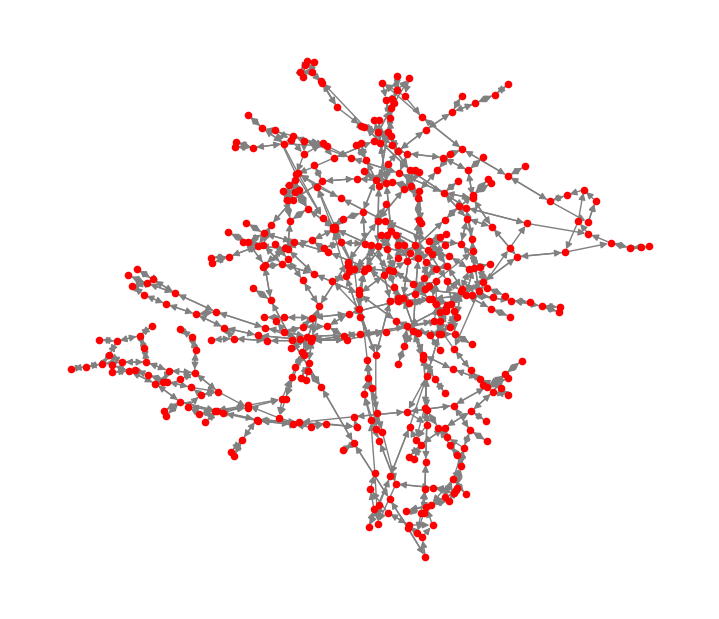

In [81]:
# Visualiser le sous-graphe avec nx.draw
plt.figure(figsize=(7,6))
nx.draw(subG, node_size=20, edge_color='gray', node_color='red')
plt.show()

> Les points rouges représentent les intersections, les traits gris les connexions (avec un sens implicite).
> La fonction `nx.draw` est une fonction de base pour visualiser des graphes dans NetworkX, sans tenir compte de la géométrie spatiale.

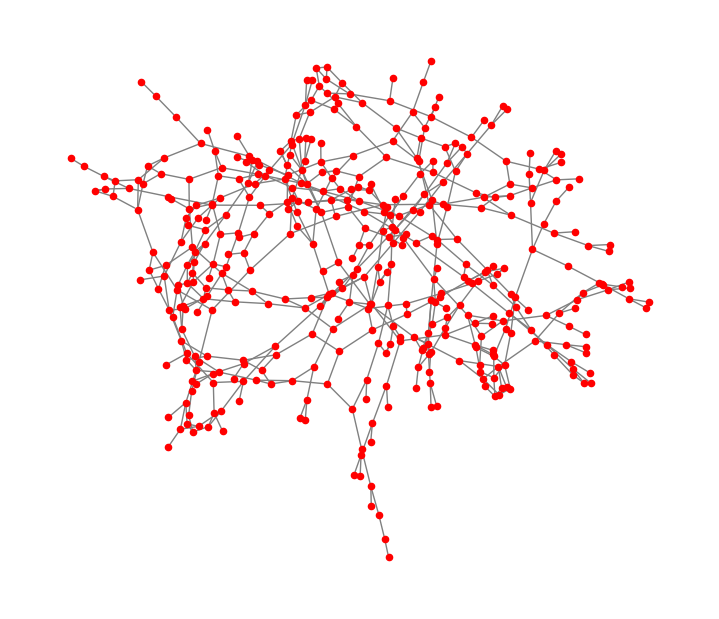

In [82]:
subG_undirected = subG.to_undirected()

plt.figure(figsize=(7,6))
nx.draw(subG_undirected, node_size=20, edge_color='gray', node_color='red')
plt.show()

> Ici le graphe est non orienté (les arêtes n'ont pas de flèches).

### Graphe géométrique avec `ox.plot_graph`

Je continue avec la fonction `ox.plot_graph` d'OSMnx pour une visualisation plus précise géométriquement.

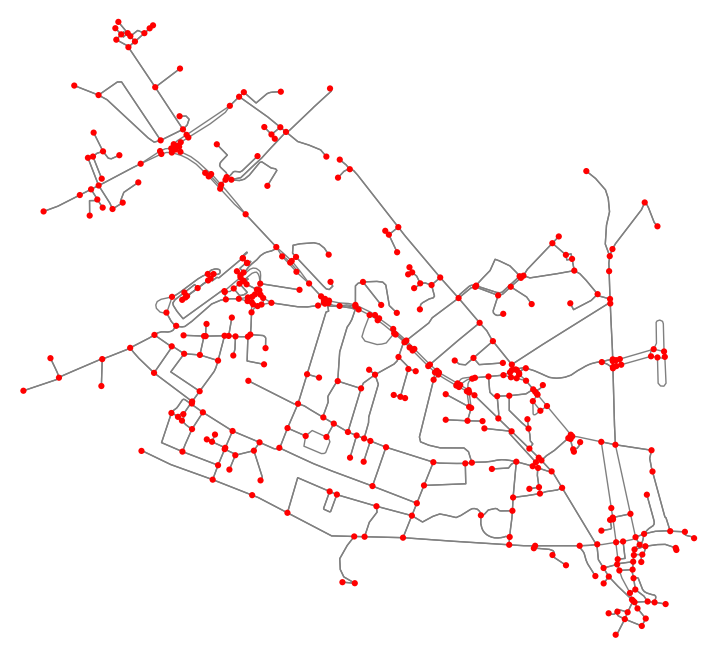

In [83]:
fig, ax = plt.subplots(figsize=(9, 20))
ox.plot_graph(
    subG,
    ax=ax,
    node_size=20,
    node_color='red',
    edge_color='gray',
    bgcolor='white'
)
plt.show()

> Le graphe montre les nœuds et arêtes selon leurs coordonnées GPS.
> La fonction `ox.plot_graph` utilise la géométrie spatiale des nœuds et des arêtes pour une visualisation plus précise géométriquement.